# Quantifying the World
### Case Study 12 - Building a Replica Neural Network Using Tensorflow
#### Kelly Carter, Swee K Chew, Vlad Orlov, Anjli Solsi

## Introduction

Utilizing the *Searching for Exotic Particles in High-Energy Physics with Deep Learning* research paper, this case study focuses on attempting to replicate the neural network architecture with various Python packages, including Tensorflow. The goal is to duplicate the paper’s original results and achieve a solution as close to the original. Another aspect of this study is to understand and identify differences between standard practices now versus when the paper was published in 2014.

## Background

Within the conversation of deep learning, neural networks are a major tool utilized and a powerful machine learning algorithm. The architecture of neural networks is inspired by the human brain. The neurons use an initial input, weighted values, and bias values to create a total input, which then goes through matrix multiplication and activation functions to output a new value. The information can be passed on to other neurons, and there can be various layers, known as hidden layers, of neurons working together to achieve the desired output. The weights of neural networks are adjusted to optimize them for the training data and improve prediction, which can be achieved by using the loss function. Just like any other model, overfitting can lead to underperformance. The benefits of neural networks are that each neuron is its own model and feeding to other neurons allows for multiple models plugging together. The versatility of combining multiple models allows this algorithm to learn from the data in advanced ways [1].

The objective of the paper is to use deep learning approaches to distingush between a signal process which produces Higgs bosons and a background process that does not. In addition, the authors want to demonstrates that use of deep learning approaches can improve the power of collider searches for exotic particles like Higgs bosons. 

Based on the paper, the input features were standardized with mean zero and standard deviation one for the training and testing sets. Features that were greater than zero were scaled to have a mean value of one. The paper defines that a subset of 2.6 million training examples and 100,000 validation examples was used in determining hyper-parameters [2].

## Methods

In this case study, we replicate the architecture describe in the paper and propose an improved architecture using current standard practices. We use loss and AUC metrics to evaluate model performance and quantify the results.

In attempt to replicate the architecture and find an optimized neural network, we will determine the number of nodes to use, number of hidden layers, which activation function works best, and define other parameters to understand how the model is influenced. Based on information in the paper, it seems as though it was becoming more common practice to train a deep neural network with at least five layers.

The dataset in the paper is based on data from the large hadron collider at CERN, which is one of the world's largest centers for scientific research. The dataset is available from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/HIGGS).

## Analysis

In [1]:
import os
import random
import numpy as np
import pandas as pd  

import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import requests
from tqdm import tqdm

import gzip

In [2]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

#### Check TensonFlow Version

In [3]:
print(tf.__version__)

2.1.0


### Get Data

First, we will download the data from the website.

In [4]:
def download_file(url, name):
    """Downloads a file from given URL and saves it as given name. 
    This function will not download file if it has already been saved."""
    if not os.path.exists(name):        
        r = requests.get(url, stream=True)
        total_size = int(r.headers.get('content-length', 0))
        block_size = 1024 #1 Kibibyte
        t=tqdm(total=total_size, unit='iB', unit_scale=True)
        with open('HIGGS.csv.gz', 'wb') as f:
            for data in r.iter_content(block_size):
                t.update(len(data))
                f.write(data)
        t.close()

In [5]:
download_file('https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz', 'HIGGS.csv.gz')

In [6]:
df = pd.read_csv('HIGGS.csv.gz', compression='gzip', header=None).sample(frac=1)

We obtain the attribute information from the website, create column names and add them to the data set.

In [7]:
df.columns = ['signal', 'lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude',
              'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt',
              'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag',
              'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv',
              'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

In [8]:
df.head()

,signal,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,...,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
7623582,1.0,0.395483,-1.754172,1.515188,1.057626,-1.082560,0.449333,1.047638,1.381110,0.000000,...,0.867341,0.193503,3.101961,1.001116,0.770735,0.978817,1.163762,0.843364,0.960941,0.849221
3347059,0.0,0.364920,2.014113,0.838812,0.864757,-0.578642,0.567049,-0.464443,-0.082544,0.000000,...,1.366202,0.485387,0.000000,1.048527,1.023695,0.987894,1.078881,0.546948,0.787172,0.775444
3182870,0.0,1.053766,1.281689,-0.874705,0.384290,1.160840,0.903614,-0.900144,0.255174,0.000000,...,0.136122,1.296668,1.550981,0.798389,0.927606,0.987858,0.842844,1.517705,1.255230,1.188311
3535504,0.0,0.713918,0.199609,1.089054,0.303784,1.656976,0.583080,-1.206125,-0.976754,0.000000,...,0.439270,-1.168357,3.101961,0.851283,0.891583,0.993705,0.728183,0.888447,0.820988,0.871303
4573526,0.0,1.019361,0.472321,1.531834,0.332160,-0.120832,1.099378,0.815924,0.884944,2.173076,...,0.895657,-1.680541,3.101961,0.952333,0.937924,0.990260,0.876588,0.857436,1.015154,0.886586


### EDA

Next, we explore the dataset by looking at the summary statistics.

In [9]:
df.shape

(11000000, 29)

We remove the target variable, *signal*, from the original data and create a new variable to store the values.

In [10]:
X = df[df.columns.difference(['signal'])].astype(float)
y = df['signal'].astype(int)

In [11]:
X.shape, y.shape

((11000000, 28), (11000000,))

In [12]:
y.describe()

count    1.100000e+07
mean     5.299203e-01
std      4.991040e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: signal, dtype: float64

The target variable, *signal*, is a binary variable with values *0* or *1*. *0* indicates a background process which does not produce Higgs bosons and *1* indicates a signal which produce Higgs bosons.

In [13]:
X.describe()

,jet 1 b-tag,jet 1 eta,jet 1 phi,jet 1 pt,jet 2 b-tag,jet 2 eta,jet 2 phi,jet 2 pt,jet 3 b-tag,jet 3 eta,...,lepton phi,m_bb,m_jj,m_jjj,m_jlv,m_lv,m_wbb,m_wwbb,missing energy magnitude,missing energy phi
count,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,...,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07
mean,9.999687e-01,-2.027520e-05,7.716199e-06,9.909152e-01,1.000008e+00,-1.026444e-05,-2.076887e-05,9.927294e-01,1.000011e+00,1.459561e-05,...,-1.327225e-05,9.729596e-01,1.034290e+00,1.024805e+00,1.009742e+00,1.050554e+00,1.033036e+00,9.598120e-01,9.985364e-01,2.613459e-05
std,1.027808e+00,1.009303e+00,1.005901e+00,4.749747e-01,1.049398e+00,1.009331e+00,1.006154e+00,4.999939e-01,1.193676e+00,1.008747e+00,...,1.006346e+00,5.254063e-01,6.746354e-01,3.808074e-01,3.974453e-01,1.645763e-01,3.652556e-01,3.133378e-01,6.000185e-01,1.006326e+00
min,0.000000e+00,-2.969725e+00,-1.741237e+00,1.375024e-01,0.000000e+00,-2.913090e+00,-1.742372e+00,1.889811e-01,0.000000e+00,-2.729663e+00,...,-1.742508e+00,4.786215e-02,7.507046e-02,1.986757e-01,1.320062e-01,8.304866e-02,2.951122e-01,3.307214e-01,2.370088e-04,-1.743944e+00
25%,0.000000e+00,-6.872450e-01,-8.680962e-01,6.789927e-01,0.000000e+00,-6.944718e-01,-8.701791e-01,6.564608e-01,0.000000e+00,-6.998083e-01,...,-8.719308e-01,6.738168e-01,7.906095e-01,8.462266e-01,7.675732e-01,9.857525e-01,8.193964e-01,7.703901e-01,5.768156e-01,-8.712081e-01
50%,1.086538e+00,-2.543566e-05,5.813991e-05,8.948193e-01,0.000000e+00,6.027267e-05,3.514990e-04,8.901377e-01,0.000000e+00,1.728937e-04,...,-2.410638e-04,8.733798e-01,8.949304e-01,9.506853e-01,9.165110e-01,9.897798e-01,9.473447e-01,8.719701e-01,8.916277e-01,2.125454e-04
75%,2.173076e+00,6.871941e-01,8.683126e-01,1.170740e+00,2.214872e+00,6.945924e-01,8.698727e-01,1.201875e+00,2.548224e+00,7.001541e-01,...,8.709940e-01,1.138439e+00,1.024730e+00,1.083493e+00,1.142226e+00,1.020528e+00,1.140458e+00,1.059248e+00,1.293056e+00,8.714708e-01
max,2.173076e+00,2.969674e+00,1.741454e+00,9.940391e+00,2.214872e+00,2.913210e+00,1.743175e+00,1.164708e+01,2.548224e+00,2.730009e+00,...,1.743236e+00,1.776285e+01,4.019237e+01,2.037278e+01,1.426244e+01,7.992739e+00,1.149652e+01,8.374498e+00,1.539682e+01,1.743257e+00


### Scale Data

Neural Networks are especially sensitive to data scaling. It is a recommended pre-processing step when working with deep neural networks as unscaled input variables can result in a slow or unstable learning process. Thus, we decided to standardize features by removing the mean and scaling to unit variance.

In [14]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [15]:
pd.DataFrame(X).describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,...,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07
mean,-7.240251e-15,-8.506814e-17,-1.976356e-17,2.261201e-18,1.722449e-14,-8.738299e-17,1.234774e-17,2.549113e-17,-1.240663e-14,9.707588e-18,...,-9.815997e-18,-1.336613e-16,-1.052148e-16,-2.941371e-16,1.483479e-16,-1.054593e-17,9.617947e-17,8.764826e-17,1.121934e-15,-2.710964e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.729144e-01,-2.942332e+00,-1.731030e+00,-1.796754e+00,-9.529349e-01,-2.886150e+00,-1.731693e+00,-1.607516e+00,-8.377582e-01,-2.706009e+00,...,-1.731506e+00,-1.760728e+00,-1.421835e+00,-2.169415e+00,-2.208444e+00,-5.878766e+00,-2.020293e+00,-2.007708e+00,-1.663781e+00,-1.733006e+00
25%,-9.729144e-01,-6.808904e-01,-8.630112e-01,-6.567140e-01,-9.529349e-01,-6.880418e-01,-8.648358e-01,-6.725455e-01,-8.377582e-01,-6.937548e-01,...,-8.664190e-01,-5.693553e-01,-3.612037e-01,-4.689463e-01,-6.093132e-01,-3.937470e-01,-5.849033e-01,-6.045294e-01,-7.028463e-01,-8.657573e-01
50%,8.422718e-02,-5.112895e-06,5.012790e-05,-2.023179e-01,-9.529349e-01,6.988505e-05,3.699908e-04,-2.051860e-01,-8.377582e-01,1.569255e-04,...,-2.263550e-04,-1.895292e-01,-2.065707e-01,-1.946380e-01,-2.345753e-01,-3.692762e-01,-2.346053e-01,-2.803426e-01,-1.781757e-01,1.852389e-04
75%,1.141369e+00,6.808802e-01,8.632110e-01,3.785991e-01,1.157677e+00,6.881816e-01,8.645725e-01,4.182958e-01,1.297013e+00,6.940687e-01,...,8.655144e-01,3.149545e-01,-1.417059e-02,1.541151e-01,3.333384e-01,-1.824430e-01,2.941030e-01,3.173440e-01,4.908512e-01,8.659664e-01
max,1.141369e+00,2.942322e+00,1.731230e+00,1.884200e+01,1.157677e+00,2.886290e+00,1.732533e+00,2.130897e+01,1.297013e+00,2.706323e+00,...,1.732256e+00,3.195602e+01,5.804332e+01,5.080778e+01,3.334471e+01,4.218218e+01,2.864702e+01,2.366356e+01,2.399640e+01,1.732272e+00


Here we split the dataset into training and test sets for the predictors and target variable. We sample 5% of the data to be the test set.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
X_train.shape, X_test.shape

((10450000, 28), (550000, 28))

### Model

In this section, we will build 2 models:
1. Neural Network model as is described in the paper (We call this model a Base Model)
1. Improved model using current standard practices

First, we will create functions to store the training and validation performance metrics for comparisons and visualizations later in the section. The callback features in Keras allows us to create a plot to show the training and validation metrics and updates the plot automatically after each epoch.

In [17]:
class History(tf.keras.callbacks.Callback):
    """ This file holds historical training and validation performance metrics.
    see https://medium.com/@kapilvarshney/how-to-plot-the-model-training-in-keras-using-custom-callback-function-and-using-tensorboard-41e4ce3cb401"""

    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.auc = []
        self.val_losses = []
        self.val_auc = []

    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}): 
        self.losses.append(logs.get('loss'))
        self.auc.append(logs.get(next(x for x in logs.keys() if x.startswith('auc'))))
        self.val_losses.append(logs.get('val_loss'))
        self.val_auc.append(logs.get(next(x for x in logs.keys() if x.startswith('val_auc'))))
        
    def get_history_df(self):
        return pd.DataFrame(data={
            'loss': self.losses,
            'validation_loss': self.val_losses,
            'auc': self.auc,
            'validation_auc': self.val_auc
        })

### Fit Base Model

Next, we create a function to bulid the base model by using the Sequential() class with different activation functions and initializers. We also include the compile step in the function to adds an optimizer (solver) and the loss metrics.

In [18]:
def build_base_model():
    initializer1 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1)
    initializer2 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05)
    initializer3 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)
    model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(300, input_shape=(28, ), activation='tanh', kernel_initializer=initializer1),
      tf.keras.layers.Dense(300, activation='tanh', kernel_initializer=initializer2),
      tf.keras.layers.Dense(300, activation='tanh', kernel_initializer=initializer2),
      tf.keras.layers.Dense(300, activation='tanh', kernel_initializer=initializer2),
      tf.keras.layers.Dense(300, activation='tanh', kernel_initializer=initializer2),
      tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=initializer3),
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

In [19]:
base_model = build_base_model()
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               8700      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 301       
Total params: 370,201
Trainable params: 370,201
Non-trainable params: 0
__________________________________________________

Here we call the *History* function we created to show the performance metrics (that are stored) when training and validating the base model. 

In [20]:
base_history = History()

We begin training and validating the base model using a *batch_size* of 100 and epochs of 10.

In [21]:
base_model.fit(X_train, y_train.values, batch_size=100,
          validation_data=(X_test, y_test), epochs=10, shuffle=True, callbacks=[base_history])

Train on 10450000 samples, validate on 550000 samples
Epoch 1/10
10450000/10450000 [==============================] - 316s 30us/sample - loss: 0.5129 - auc: 0.8224 - precision: 0.7497 - recall: 0.7680 - val_loss: 0.5011 - val_auc: 0.8325 - val_precision: 0.7487 - val_recall: 0.7938
Epoch 2/10
10450000/10450000 [==============================] - 257s 25us/sample - loss: 0.5015 - auc: 0.8315 - precision: 0.7569 - recall: 0.7757 - val_loss: 0.5005 - val_auc: 0.8341 - val_precision: 0.7782 - val_recall: 0.7386
Epoch 3/10
10450000/10450000 [==============================] - 255s 24us/sample - loss: 0.4994 - auc: 0.8332 - precision: 0.7582 - recall: 0.7780 - val_loss: 0.4978 - val_auc: 0.8346 - val_precision: 0.7631 - val_recall: 0.7688
Epoch 4/10
10450000/10450000 [==============================] - 304s 29us/sample - loss: 0.4990 - auc: 0.8336 - precision: 0.7585 - recall: 0.7782 - val_loss: 0.4968 - val_auc: 0.8358 - val_precision: 0.7721 - val_recall: 0.7572
Epoch 5/10
10450000/10450000 [

### Visualize Results

We extract the stored performance metrics to create plots to show the training and validation metric values at each epoch for the base model.

[Text(0, 0.5, 'loss'),
 Text(0.5, 0, 'Epoch'),
 Text(0.5, 1.0, 'Historical loss (base model)')]

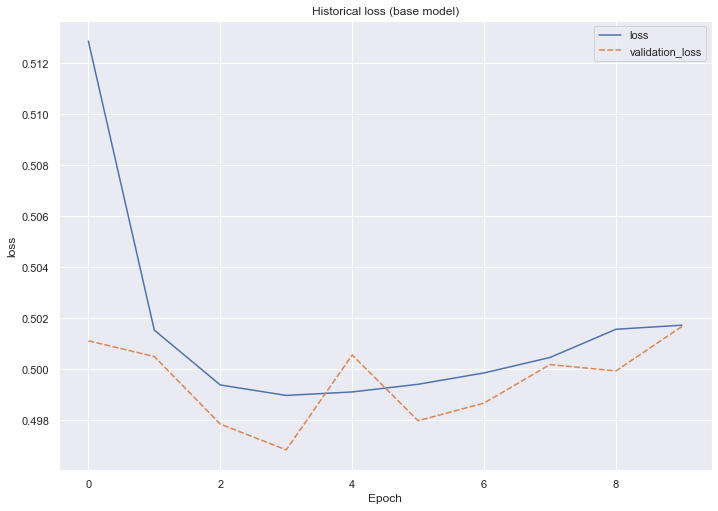

In [32]:
ax = sns.lineplot(data=base_history.get_history_df()[['loss', 'validation_loss']])
ax.set(xlabel='Epoch', ylabel='loss', title='Historical loss (Base model)')

<center>**Figure 1:** Loss and Validation Loss at Each Epoch for the Base Model</center>

[Text(0, 0.5, 'AUC'),
 Text(0.5, 0, 'Epoch'),
 Text(0.5, 1.0, 'Historical AUC (base model)')]

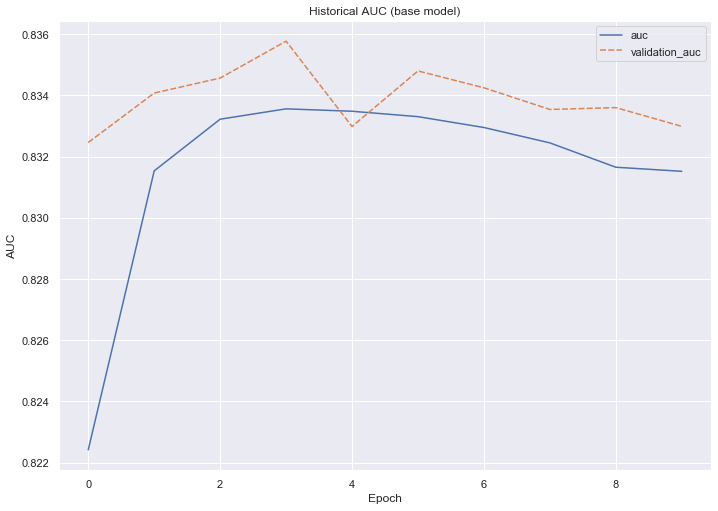

In [33]:
ax = sns.lineplot(data=base_history.get_history_df()[['auc', 'validation_auc']])
ax.set(xlabel='Epoch', ylabel='AUC', title='Historical AUC (base model)')

<center>**Figure 2:** AUC and Validation AUC at Each Epoch for the Base Model</center>

Figure 1 shows the performance for the loss and validation loss metrics at each epoch as we train and validate the base model, whereas Figure 2 shows the performance for the AUC and validation AUC metrics. 

From Figure 2, we can see that training AUC has crossed validation AUC at 5th epoch indicating model overfit (Please note that the plot begins at index 0). After that, the validation loss metric increases (as shown in Figure 1) and the validation AUC metric continues to drop. We do not need to train the Base Model for 10 epochs, 4 epochs are more than enough for this model and the best validation AUC value we could get is 0.8358.

### Fit Improved Model

Next we improve the previous base model by using:

    * He Uniform initializer proposed in this paper [3]
    * Dropout proposed by Geoffrey Hinton
    * RELU and Batch Normalization to aid with vanishing/exploding gradient

We also create a function to bulid the improved model by using the Sequential() class and implementation the methods mentioned above. We also include the compile step in the function to adds an optimizer (solver) and the loss metrics.

In [23]:
def build_our_model():
    model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(300, input_shape=(X.shape[1], ), activation='relu', kernel_initializer='he_uniform'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_uniform'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_uniform'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_uniform'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_uniform'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_uniform'),
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

In [29]:
our_model = build_our_model()
our_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 300)               8700      
_________________________________________________________________
dropout_7 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_8 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_9 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)              

Again, we call the *History* function we created to show the performance metrics (that are stored) when training and validating the improved model. 

In [30]:
our_history = History()

Then we begin training and validating the improved model using a *batch_size* of 100 and epochs of 10.

In [31]:
our_model.fit(X_train, y_train.values, batch_size=100,
          validation_data=(X_test, y_test), epochs=10, shuffle=True, callbacks=[our_history])

Train on 10450000 samples, validate on 550000 samples
Epoch 1/10
10450000/10450000 [==============================] - 356s 34us/sample - loss: 0.5160 - auc_2: 0.8205 - precision_2: 0.7487 - recall_2: 0.7677 - val_loss: 0.4841 - val_auc_2: 0.8454 - val_precision_2: 0.7785 - val_recall_2: 0.7659
Epoch 2/10
10450000/10450000 [==============================] - 360s 34us/sample - loss: 0.4919 - auc_2: 0.8394 - precision_2: 0.7627 - recall_2: 0.7859 - val_loss: 0.4771 - val_auc_2: 0.8511 - val_precision_2: 0.7569 - val_recall_2: 0.8212
Epoch 3/10
10450000/10450000 [==============================] - 358s 34us/sample - loss: 0.4861 - auc_2: 0.8436 - precision_2: 0.7657 - recall_2: 0.7903 - val_loss: 0.4736 - val_auc_2: 0.8540 - val_precision_2: 0.7774 - val_recall_2: 0.7905
Epoch 4/10
10450000/10450000 [==============================] - 355s 34us/sample - loss: 0.4828 - auc_2: 0.8461 - precision_2: 0.7679 - recall_2: 0.7922 - val_loss: 0.4739 - val_auc_2: 0.8554 - val_precision_2: 0.7721 - val

### Visualize Results

We extract the stored performance metrics to create plots to show the training and validation metric values at each epoch for the improved model.

[Text(0, 0.5, 'loss'),
 Text(0.5, 0, 'Epoch'),
 Text(0.5, 1.0, 'Historical loss (base model)')]

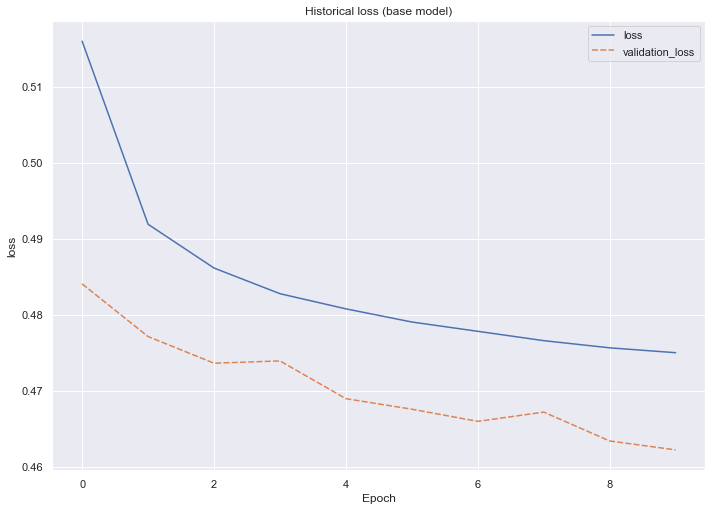

In [34]:
ax = sns.lineplot(data=our_history.get_history_df()[['loss', 'validation_loss']])
ax.set(xlabel='Epoch', ylabel='loss', title='Historical loss (base model)')

<center>**Figure 3:** Loss and Validation Loss at Each Epoch for the Improved Model</center>

[Text(0, 0.5, 'AUC'),
 Text(0.5, 0, 'Epoch'),
 Text(0.5, 1.0, 'Historical AUC (base model)')]

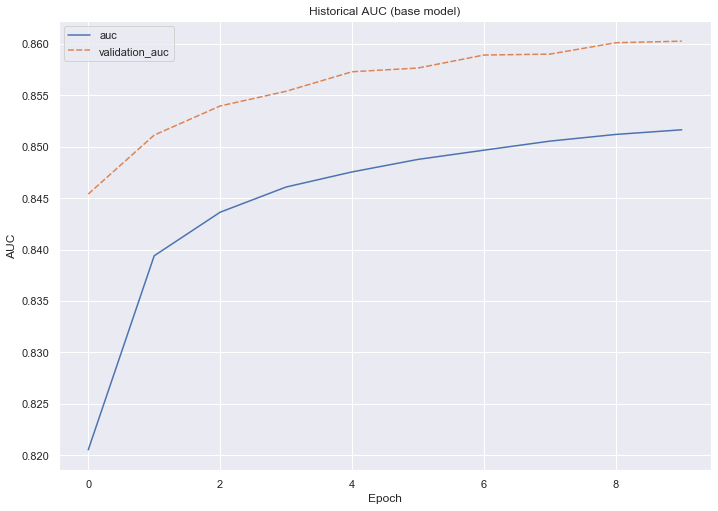

In [35]:
ax = sns.lineplot(data=our_history.get_history_df()[['auc', 'validation_auc']])
ax.set(xlabel='Epoch', ylabel='AUC', title='Historical AUC (base model)')

<center>**Figure 4:** AUC and Validation AUC at Each Epoch for the Improved Model</center>

Figure 3 shows the performance for the loss and validation loss metrics at each epoch as we train and validate the improved model, whereas Figure 4 shows the performance for the AUC and validation AUC metrics. 

From Figure 4, we can see that the peak of the validation AUC reaches 0.8603 at the 10th epoch and it seems to continue to increase after that. The validation loss also seems to continue to decrease after the 10th epoch as shown in Figure 3. 

Since the training AUC is smaller than the validation AUC even at the 10th epoch, we believe that we could achieve a higher validation AUC if we continue to train our improved model for more epochs.

## Conclusion 

When this paper was written in 2014, their neural network model used random normal initializers of varying sizes for input, hidden and output layers and hyperbolic tangent activation functions. For this baseline model, a five-layer neural network with 300 hidden units in each layer was used, the same as the model created in the paper.

We improved the model by implementing He Uniform initializers and ReLU activation functions. He Uniform insures variance scaling with allowance for the number of inputs units in the weight tensor [4]. ReLU, which stands for rectified linear unit, has now become one the most commonly used activation functions for neural networks due to its many benefits including cheap computation, fast converging, and its sparsity. [5] ReLU along with the usage of batch normalization is used to minimize vanishing/exploding gradients. The final improvement implemented was the use of dropout, which helps prevent overfitting the data [6]. Our final model uses six layers with differentiating hidden unit sizes, dropout after each layer and batch normalization after the second and fourth layer.
 
We were able to able to validate the results in the paper by calculating the loss, validation loss, AUC, and validation AUC at each epoch. By implementing the mentioned improvements to the baseline model, we increased the validation AUC value from 0.8358 to 0.8603 when using 10 epochs, which is 0.02 away from the result that authors of the paper have achieved. Further studies should include fitting the improved models with an increased number of epochs as the AUC appeared to continue increasing in value.


### Sources

[1] https://archive.ics.uci.edu/ml/datasets/HIGGS

[2] https://arxiv.org/abs/1402.4735

[3] https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf

[4] https://keras.io/initializers/

[5] https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7

[6] https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout